## **Imports**

In [1]:
!pip uninstall -y -q datasets
!pip install -q --no-deps "transformers==4.52.4"
!pip install -q --no-deps "datasets>=2.19.2"
!pip install -q evaluate accelerate sklearn-compat pyarrow sentencepiece tqdm seaborn matplotlib

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel , EarlyStoppingCallback,DataCollatorWithPadding
from datasets import Dataset
import re
from tqdm import tqdm
#import paths_ml_task_1 as PATHS
from transformers import DataCollatorWithPadding
from sklearn.preprocessing import LabelEncoder
import os
from pathlib import Path
from tqdm.notebook import tqdm
from transformers.modeling_outputs import SequenceClassifierOutput
from google.colab import files

# **Experiment: Evaluating the Impact of Preprocessing Strategies on Classification Performance**

**TL;DR:** In this experiment, we systematically assess how varying levels of text normalization affect classification performance for both SVMs and BERT models. To ensure fairness and comparability, all models are trained and evaluated on the *same set of 1,000 speeches*, each identified via a unique speech ID across preprocessing variants. We find that preprocessing plays a pivotal — yet model-dependent — role in downstream accuracy and class balance. The unprocessed dataset (`data_set_7`) serves as a neutral baseline for all comparisons.


---


## **Context and Objective**

- This experiment complements earlier findings on [vectorization](ML-Task-1_Vectorization-Experiment.ipynb) and [speech length](ML-Task-1_Speech-Length-Experiment.ipynb), offering a structured evaluation of how various levels of text normalization (e.g., lowercasing, stopword removal) may influence downstream classification models' performance.

- Again, our objective at the moment is **not primarily to maximize model performance**, but rather to perform a **evidence-based trend and impact analysis** quantifying the influence of linguistic normalization decisions on text classification performance, by isolating the effectiveness of preprocessing pipelines.


---


## **Generate DataSets using the [Preprocessing Pipeline](../dataPreprocessingHelpers/preprocessing_pipeline.py)**


We apply a structured and modular preprocessing pipeline that allows for fine-grained control over normalization levels. Each stage introduces a specific linguistic transformation:

Each resulting dataset is labeled as `data_set_1` through `data_set_7`, where `data_set_7` corresponds to the **original, unprocessed speeches**, and serves as a **neutral baseline** for model performance comparisons.


- To generate the datasets for the comparison from Bundestags speech data ('speech_content' column), we apply our structured and modular **[Preprocessing Pipeline](../dataPreprocessingHelpers/preprocessing_pipeline.py)** that allows for fine-grained control over linguistic normalization levels:
    - **Level 1 – Minimal Processing:** Lowercasing, punctuation removal, and Unicode normalization
    - **Level 2 – Token and Word Filtering:** Stopword removal
    - **Level 3 – Linguistic Normalization:** Lemmatization and/or stemming via spaCy and NLTK
    - **Level 4 – Extended Cleaning:** Removal of custom domain-specific formulaic phrases and stopwords
- This pipeline is heavily parallelized using all available CPU cores and allows to process multiple independent dataset configurations at a time using Python’s multiprocessing backend. For this experiment, a number of Dataset Configurations of varying levels are prepared in [Preprocessing_ML-Task-1_Classification.py](Preprocessing_ML-Task-1_Classification.py).


### **Data Set Configurations:**

| Name       | Model    | Lowercase | Remove digits | Remove punctuation | Remove stopword | Remove domain specific stopwords | Phrase pattern removal | Contribution Mode | Merge factions      | Remove faction  | Remove group                               |
|------------|----------|-----------|---------------|--------------------|-----------------|----------------------------------|------------------------|-------------------|---------------------|-----------------|--------------------------------------------|
| data_set_1 | SVM      | Yes       | Yes           | Yes                | Yes             | Yes                              | Yes                    | REMOVE            | BSW into DIE LINKE. | `faction_id=-1` | `position_short="Presidium of Parliament"` |
| data_set_2 | SVM      | Yes       | Yes           | Yes                | Yes             | No                               | Yes                    | REMOVE            | BSW into DIE LINKE. | `faction_id=-1` | `position_short="Presidium of Parliament"` |
| data_set_3 | SVM      | Yes       | No            | No                 | No              | No                               | No                     | INSERT            | BSW into DIE LINKE. | `faction_id=-1` | `position_short="Presidium of Parliament"` |
| data_set_6 | SVM      | Yes       | No            | No                 | Yes             | No                               | No                     | INSERT            | BSW into DIE LINKE. | `faction_id=-1` | `position_short="Presidium of Parliament"` |
| data_set_4 | BERT     | No        | Yes           | Yes                | Yes             | Yes                              | Yes                    | REMOVE            | BSW into DIE LINKE. | `faction_id=-1` | `position_short="Presidium of Parliament"` |
| data_set_5 | BERT     | No        | No            | No                 | Yes             | No                               | No                     | INSERT            | BSW into DIE LINKE. | `faction_id=-1` | `position_short="Presidium of Parliament"` |
| data_set_7 | baseline | No        | No            | No                 | No              | No                               | No                     | INSERT            | BSW into DIE LINKE. | `faction_id=-1` | `position_short="Presidium of Parliament"` |
| data_set_8 | none     | Yes       | No            | No                 | No              | No                               | Yes                    | REMOVE            | BSW into DIE LINKE. | `faction_id=-1` | `position_short="Presidium of Parliament"` |
| data_set_9 | BERT     | No        | No            | No                 | No              | No                               | Yes                    | REMOVE            | BSW into DIE LINKE. | `faction_id=-1` | `position_short="Presidium of Parliament"` |

> - **Note:** All the configuration dictionaries and processing initalization are kept [separateley](Preprocessing_ML-Task-1_Classification.py) because of some weird issues I ran into regarding Python’s multiprocessing backend in combination with Jupyter.
> - Configuration details shared across all datasets:
  `only_valid_faction_id=True`,
  `position_short=["Presidium of Parliament", "Guest"]`,
  `tokenization=True`, `lemmatization=True`, `stemming=True`,
  `add_char_count=True`, `add_token_count=True`, `add_lemma_count=True`


### **Input:**
```
data/
├── dataFinalStage/
│   ├── speechContentFinalStage/
│   │   ├── speech_content_19.pkl
│   │   └── speech_content_20.pkl
```


### **Output:**
```
data/
├── dataPreprocessedStage/
│   ├── dataClassification/
│   │   ├── dataSets/
│   │   │   ├── data_set_<1-9>_19_20.xlsx
│   │   │   ├── data_set_<1-9>_19.xlsx
│   │   │   ├── data_set_<1-9>_20.xlsx
│   │   │   ├── data_set_<1-9>_19_20.pkl
│   │   │   ├── data_set_<1-9>_19.pkl
│   │   │   └── data_set_<1-9>_20.pkl
```


---


## **Methodology**
- **Sampling Strategy:**
    - Initial length-based filtering removes speeches outside the central 65 % speech length range: the shortest (lower 25 % percentile) and longest (upper 90 % percentile) speeches are excluded.
    - To ensure comparability, all models are evaluated and trained on the exact same subset of speeches: Therefore, we randomly select 1,000 speeches by their unique id, **ensuring comparability across all datasets**.
- **Train-Test Split:** One stratified 80/20 split (also based on the speeches' ids) with fixed random seed for reproducibility is used for **all models**. The trained models are evaluated on the 20 % hold-out set.
- **Model Configurations:**
    - **Linear Support Vector Machine** (`LinearSVC` classifier from scikit-learn with a fixed `random_state=42`):
        - **TF-IDF Vectorizer Settings:**
            - `ngram_range=(1, 3)` → unigrams to trigrams
            - `max_features=50000`
            - `min_df=3` → removes very rare words
            - `max_df=0.5` → removes overly frequent, generic words
    - **BERT model:** `bert-base-german-cased` model from HuggingFace Transformers is used as a pretrained encoder. The encoders' outputs are then passed on to a custom linear classification head, using mean pooling (Computes the mean of all token embeddings, weighted by the attention mask, to obtain a sentence embedding) as an embedding strategy.
        - **Tokenizer:** `BertTokenizer` from HuggingFace, configured with `padding="max_length"` and `truncation=True` to enforce a hard 512 tokens input-length limit.
        - **Training Hyperparameters:**
          - Epochs: 3
          - Batch size: 8
          - Learning rate: 1e-5
          - Evaluation strategy: `epoch`
          - Evaluation and prediction steps use HuggingFace's Trainer API
          - Optimizer: AdamW (implicitly used by the Trainer)
          - Fixed `random_seed` (`SEED = 42`)
    - All training procedures are conducted with **fixed random seeds** and **constant hyperparameters** across runs to ensure experimental control.


---


## **Evaluation**


To assess model behavior under varying preprocessing conditions, we apply the following metrics for each model-preprocessing combination:
- **Accuracy:** Overall proportion of correctly classified speeches.
- **Macro F1-Score:** Harmonic mean of precision and recall, averaged equally across classes (mitigates class imbalance effects).
- **Confusion Matrix:** Visualizes inter-class confusion patterns and highlights which parties are frequently misclassified.
- **Qualitative Sample Inspection:** Review preprocessed text of correctly and incorrectly classified samples from each variant to evaluate if they are still interpretable or result in “dead”, empty texts.

In line with our evidence-based philosophy, we use model performance on `data_set_7` (no normalization) as a **reference baseline**. All other results are interpreted as **relative gains or losses** in comparison to this unprocessed variant to ultimately identify **which preprocessing steps support — or hinder — learning for each model type**.


### **Expectations** (based on these assumtions we choose our dataset configurations)
- TF-IDF models benefit from **aggressive preprocessing** (removing noise, reducing vocabulary size)
- Deep models are **sensitive to aggressive preprocessing**
  → Removing stopwords/punctuation may degrade performance due to **loss of syntactic/semantic structure**


### **Model-Specific Expectations and Interpretive Framework**

It is critical to emphasize that **preprocessing cannot be considered a universally beneficial or detrimental operation**: its effectiveness is strongly model-dependent, owing to fundamental differences in how classical and deep learning architectures encode language.

**Traditional models like SVMs** based on surface-level statistical regularities are highly **sensitive to sparsity, vocabulary size, and noise**. Accordingly, we expect performance gains through aggressive normalization:
- **Strong improvements with heavier preprocessing**, particularly through:
  - Stopword removal → reduces dimensionality without meaningful information loss
  - Lemmatization/stemming → increases token consistency and term frequency
  - Punctuation and casing normalization → reduces spurious feature variance

**Deep transformer-based models like BERT**, in contrast, are **pretrained on raw, naturalistic language** and exploit **contextual dependencies**, token position, and syntax. Hence:
- Even **minor normalization** like lowercasing could negatively impact a cased models' learning performance
- **Overly aggressive preprocessing** (e.g., removing stopwords or punctuation) may disrupt syntactic structure, which can negatively affect attention mechanisms and downstream representations.
- Thus, we expect BERT models to perform best on **lightly normalized or even raw inputs**, where the full richness of linguistic cues is preserved.


### **Conclusion**

By systematically varying preprocessing strategies and evaluating their downstream effects, this experiment provides nuanced insight into the compatibility of linguistic normalization with different model architectures. In the future these findings can help us design preprocessing pipelines not by intuition, but by **empirical alignment with model-specific requirements**.


---


## **Idea for future extensions:**

**Named Entity Removal** as an additional option provided by the Preprocessing Pipeline could help reduce personalization or named references and would be interesting to evaluate.

In [ ]:
"""
Generating Datasets via the Preprocessing pipeline and splitting data
"""
#!python preprocessing_ML-Task-1_classification.py
!python preprocessing_experiment_sampling_strategy.py

/Users/jantischner/Library/CloudStorage/OneDrive-Personal/TH_OHM_B.Sc.Inf/Th-Ohm_B.Sc.Inf_Sem4/NLP_Sem-4/team-16_local_Preprocessing/ML-Task-1_Classification/preprocessing_experiment_sampling_strategy.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  invalid_mask.loc[:, str_cols] |= blank_mask
/Users/jantischner/Library/CloudStorage/OneDrive-Personal/TH_OHM_B.Sc.Inf/Th-Ohm_B.Sc.Inf_Sem4/NLP_Sem-4/team-16_local_Preprocessing/ML-Task-1_Classification/preprocessing_experiment_sampling_strategy.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  invalid_mask.loc[:, str_cols] |= bla

Running on: cuda
[SVM]  Training → SVM_DS_7_20    (800 Train / 201 Test)
[SVM]  Training → SVM_DS_1_20    (800 Train / 201 Test)
[SVM]  Training → SVM_DS_2_20    (800 Train / 201 Test)
[SVM]  Training → SVM_DS_3_20    (800 Train / 201 Test)
[BERT] Training → BERT_DS_7_20   (800 Train / 41 Val / 160 Test)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

/tmp/ipython-input-8-3447378473.py:218: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.926400,1.851343,0.268293,0.176798
2,1.664400,1.602253,0.292683,0.253201
3,1.319900,1.392258,0.341463,0.280615


[BERT] Training → BERT_DS_4_20   (800 Train / 41 Val / 160 Test)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

/tmp/ipython-input-8-3447378473.py:218: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.945000,1.855009,0.292683,0.210750
2,1.782800,1.690362,0.268293,0.200474
3,1.598100,1.633190,0.195122,0.174397


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[BERT] Training → BERT_DS_5_20   (800 Train / 41 Val / 160 Test)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

/tmp/ipython-input-8-3447378473.py:218: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.932200,1.842942,0.317073,0.220768
2,1.676400,1.557845,0.365854,0.356054
3,1.292400,1.295626,0.512195,0.467264


[BERT] Training → BERT_DS_9_20   (800 Train / 41 Val / 160 Test)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

/tmp/ipython-input-8-3447378473.py:218: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.945700,1.893684,0.243902,0.150845
2,1.735400,1.734909,0.292683,0.250299
3,1.506700,1.695760,0.292683,0.284549



### Evaluation Results for Model: **SVM_DS_7_20**

**Confusion Matrix (absolute counts)**

|            |   CDU/CSU |   SPD |   Die Grünen |   AfD |   FDP |   DIE LINKE. |
|:-----------|----------:|------:|-------------:|------:|------:|-------------:|
| CDU/CSU    |        28 |     0 |            0 |     1 |     0 |            0 |
| SPD        |         3 |    22 |            1 |     0 |     2 |            0 |
| Die Grünen |         0 |     1 |           25 |     0 |     1 |            0 |
| AfD        |         0 |     0 |            0 |    24 |     0 |            1 |
| FDP        |         0 |     1 |            0 |     0 |    25 |            0 |
| DIE LINKE. |         1 |     0 |            0 |     0 |     0 |           27 |

**Classification Report**

            precision  recall  f1-score  support
CDU/CSU         0.875   0.966     0.918     29.0
SPD             0.917   0.759     0.830     29.0
Die Grünen      0.926   0.893     0.909     28.0
AfD             0.750   0.857     0.

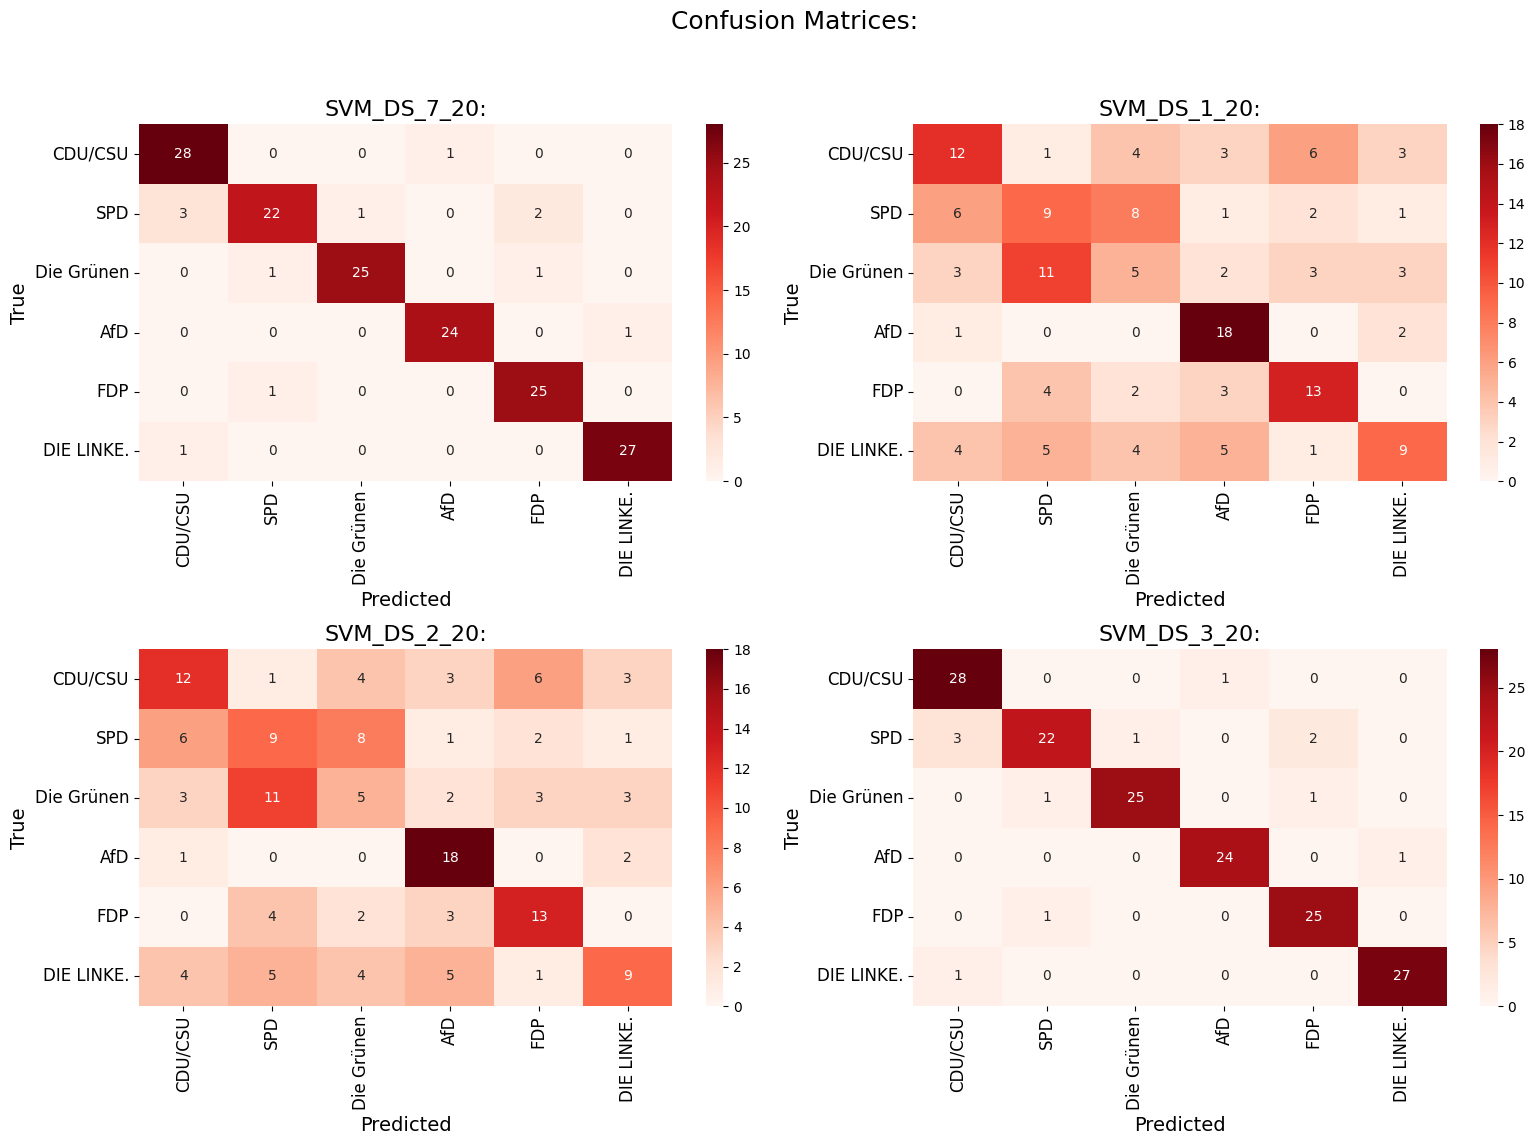

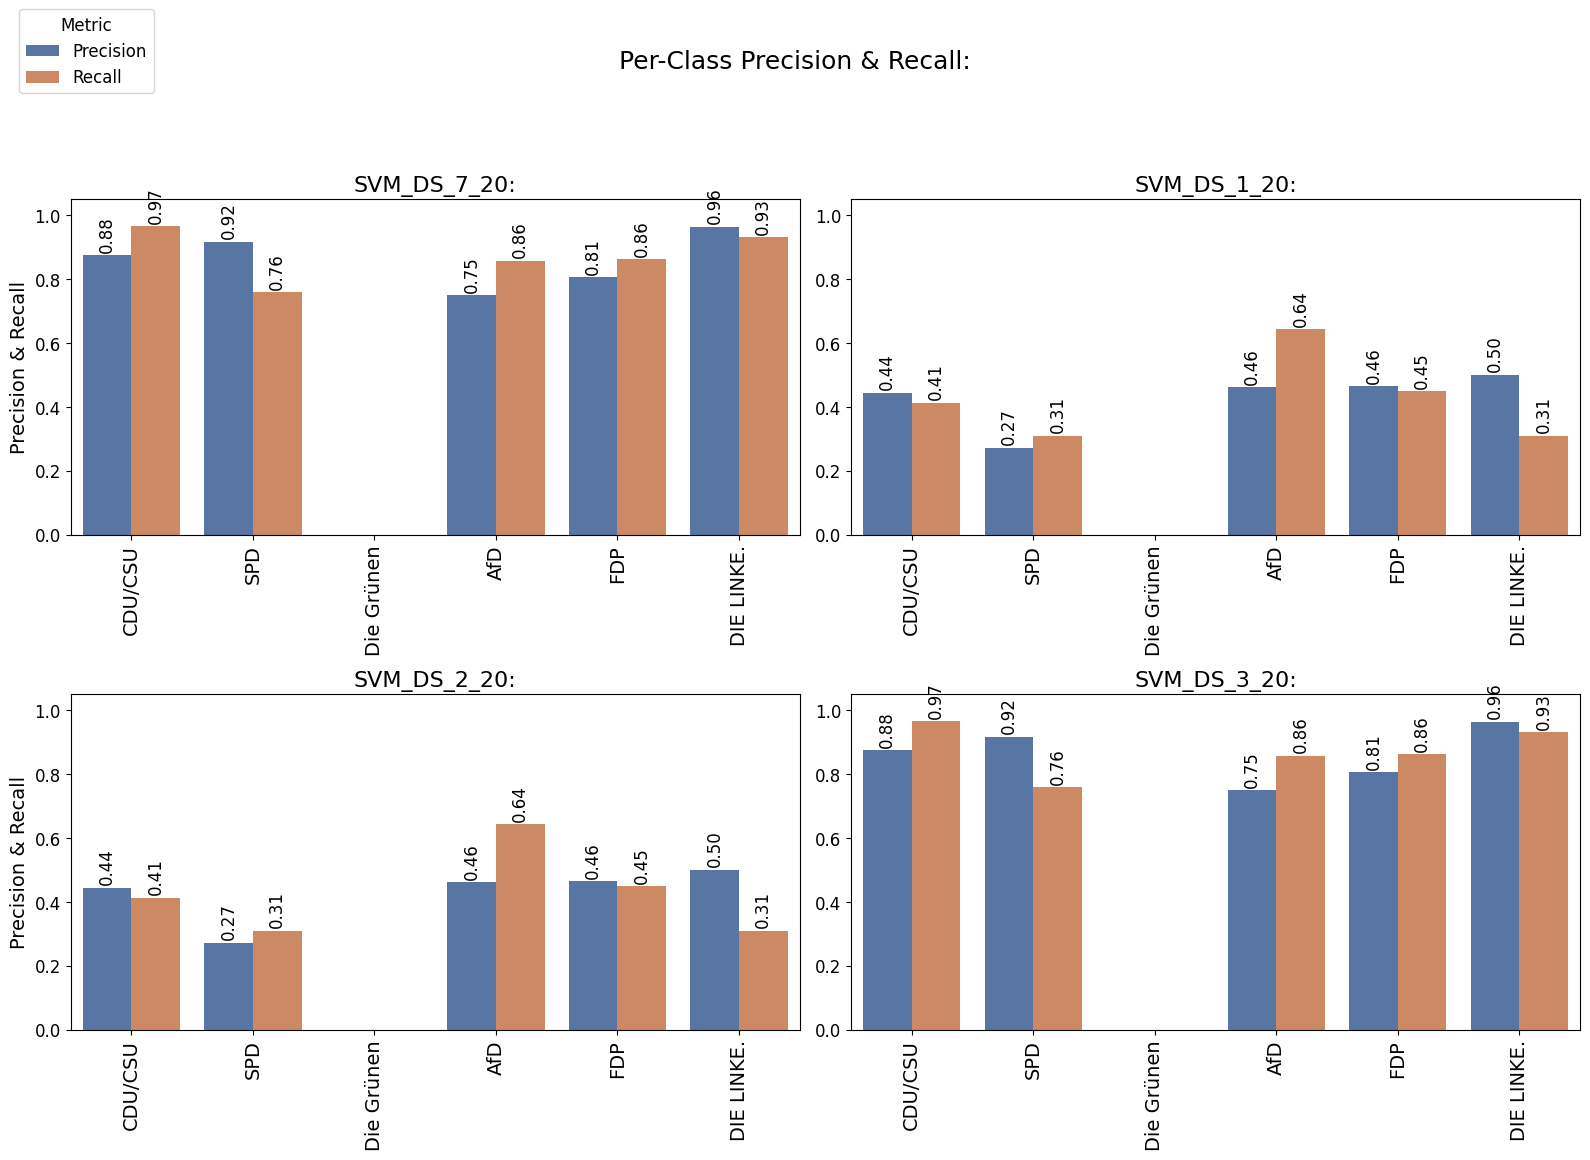

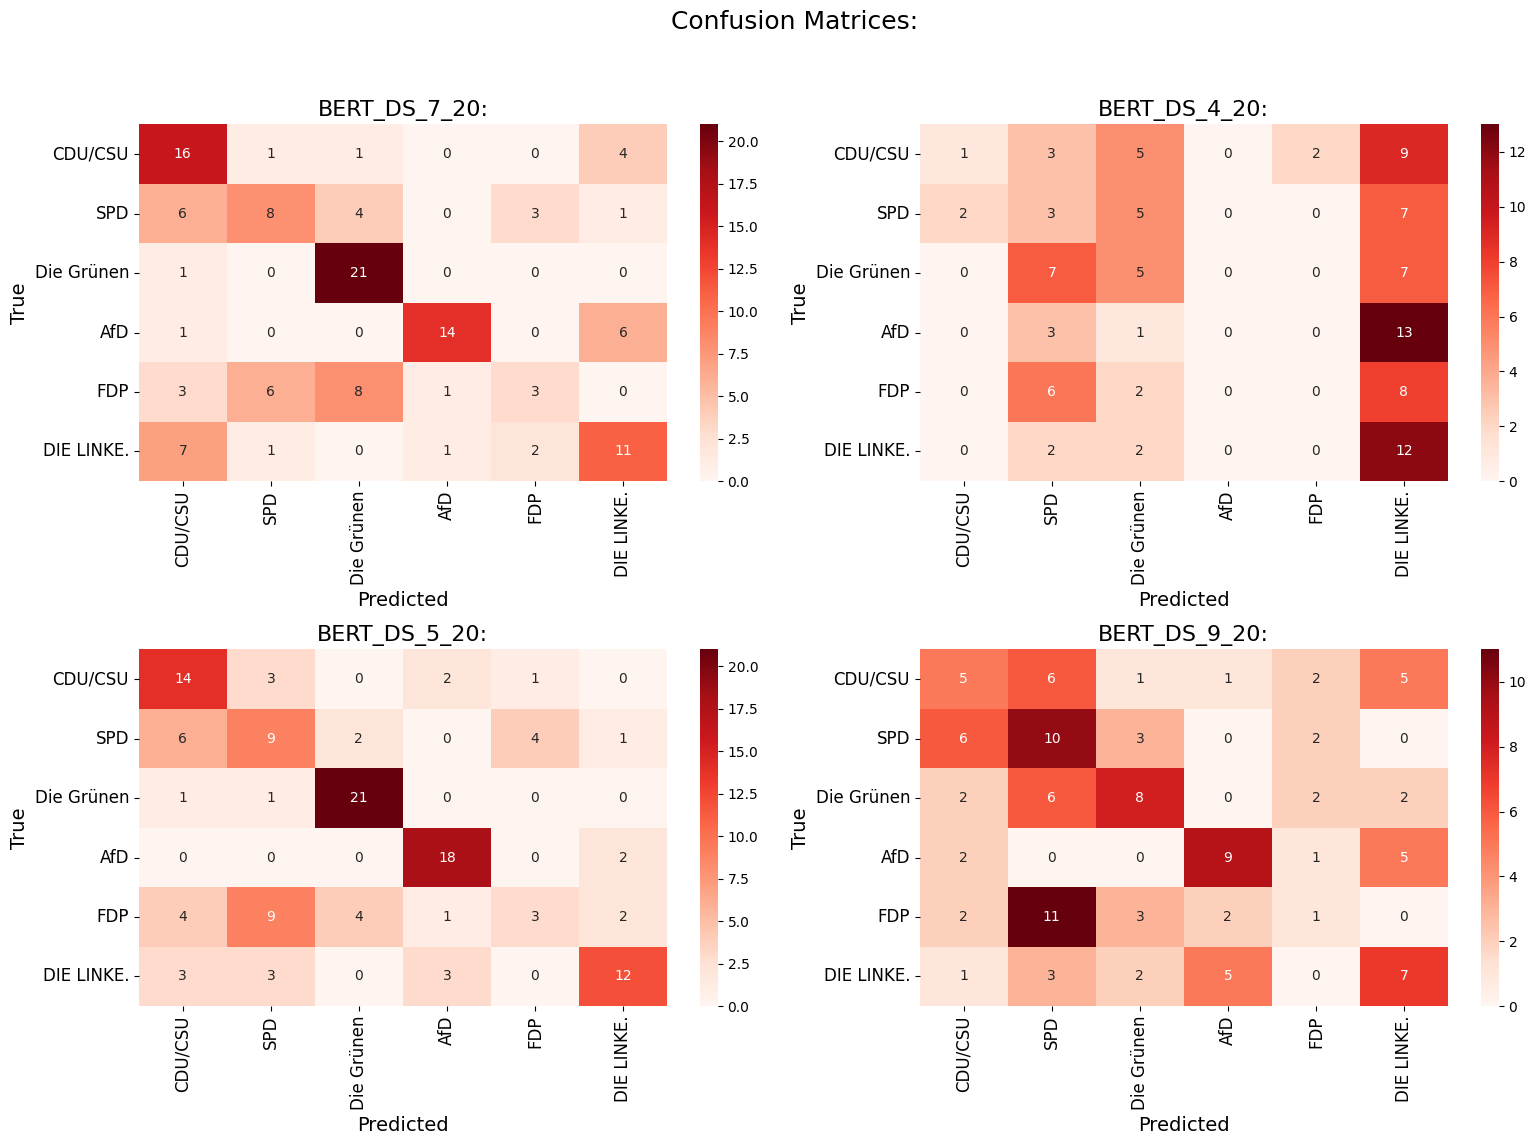

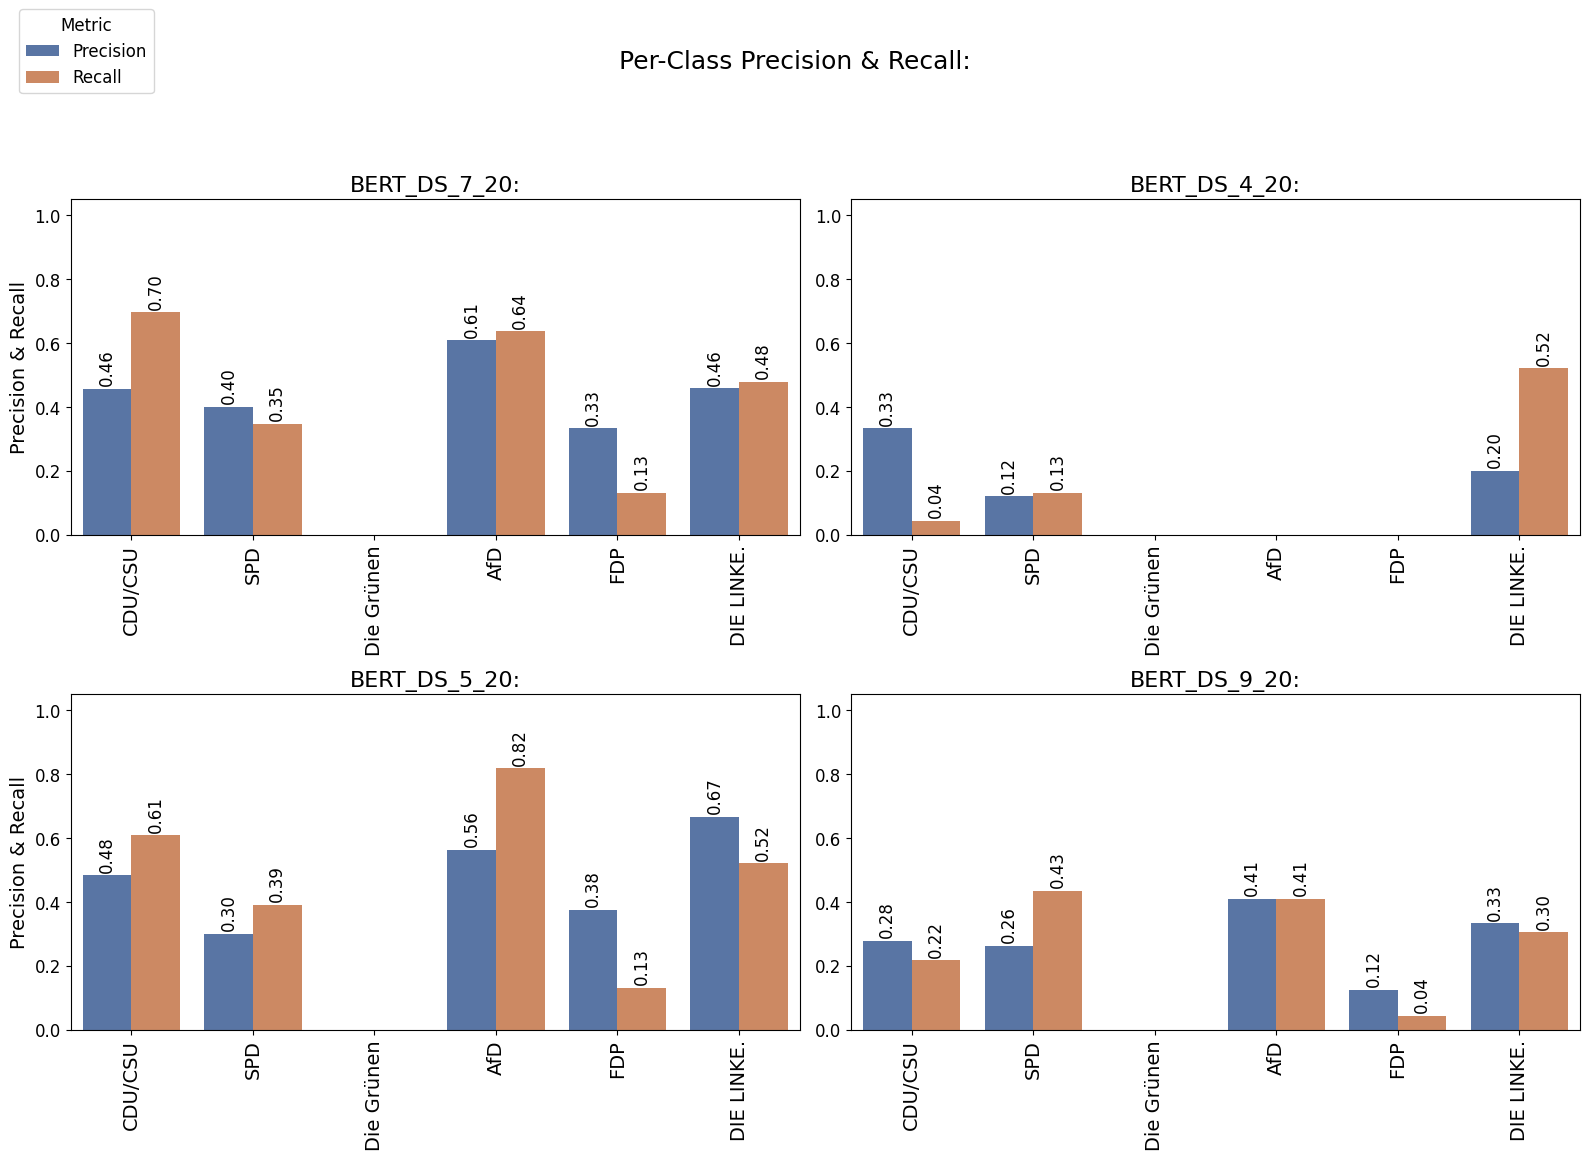

In [8]:

"""
Setup constants
"""
# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# Models & Tokenizer
MODEL_NAME = "bert-base-german-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
LEARNING_RATE = 1e-5
NUM_LABELS = 6  # will later also be adjustet based on the number of uniqe parties in the dataset
BATCH_SIZE = 8
EPOCHS = 3
MAX_SAMPLE_SIZE_PARTY=1000 # speech counts of parties need to be double checked after filtering
TEST_SPLIT_SIZE=0.2
MAX_FEATURES = 50000
NGRAM_RANGE = (1, 3)
MIN_DF = 3
MAX_DF = 0.5
UPPER_PERCENTILE = 0.9
LOWER_PERCENTILE = 0.25
MAX_LENGTH_BERT = 512
SPEECH_ID_COL: str = "id"
LENGTH_COL: str = "speech_length_chars"
LABEL_COL: str = "faction_id"
ABBR_COL: str = "faction_abbreviation"
# Datsts
SVM_DATASETS  = [7, 1, 2, 3]
BERT_DATASETS = [7, 4, 5, 9]



"""
Global variables
"""
# Global dictionary to store all confusion matrices by model name
confusion_matrices = {}
# Global dictionary to collect classification reports per model
classification_reports = {}
# Load faction map
faction_map = pd.read_pickle("factionsAbbreviations.pkl").drop_duplicates(subset="id").set_index("id")["abbreviation"]
# Set device type explicitly for MPS (Apple Silicon), CUDA or CPU
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
print(f"Running on: {device}")
model_encoders: dict[str, LabelEncoder] = {}



class BertMeanPoolingClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = output.last_hidden_state # (B, L, H)
        mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
        summed_vectors = (hidden_states * mask).sum(dim=1)   # (B, H)
        valid_tokens   = mask.sum(dim=1) # (B, 1)
        mean_pooled    = summed_vectors / torch.clamp(valid_tokens, min=1e-9)
        logits = self.classifier(mean_pooled) # classification
        # loss:
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}



"""
Tokenization and dataset conversion
"""
def tokenize_function_stopword(examples, max_length): # here without padding -> need data collator later
    """
    Tokenizes input text using BertTokenizer with specific max token length.

    :param: examples (dict): Dictionary containing the key "speech_content" with raw text.
    :param: max_length (int): Maximum number of tokens after padding/truncation.

    :return: tokenized_output (dict): Dictionary with input_ids and attention masks.
    """
    return tokenizer(examples["speech_content_stopword"], truncation=True, max_length=max_length)

def tokenize_function_cleaned(examples, max_length): # here without padding -> need data collator later
    """
    Tokenizes input text using BertTokenizer with specific max token length.

    :param: examples (dict): Dictionary containing the key "speech_content" with raw text.
    :param: max_length (int): Maximum number of tokens after padding/truncation.

    :return: tokenized_output (dict): Dictionary with input_ids and attention masks.
    """
    return tokenizer(examples["speech_content_cleaned"], truncation=True, max_length=max_length)


def prepare_dataset_BERT_cleaned(df_subset, max_len):
    """
    Prepares and tokenizes dataset from dataframe for BERT model training.

    :param: df_subset (pd.DataFrame): DataFrame containing speeches and encoded labels.
    :param: max_len (int): Maximum token length.

    :return: df_tokenized (Dataset): Tokenized and formatted dataset compatible with PyTorch.
    """
    df_dataset = Dataset.from_pandas(df_subset[["speech_content_cleaned", "label_encoded"]])
    df_tokenized = df_dataset.map(lambda x: tokenize_function_cleaned(x, max_len), batched=True)
    df_tokenized = df_tokenized.rename_column("label_encoded", "labels")

    cols = ["input_ids", "attention_mask", "labels"]
    if "token_type_ids" in df_tokenized.column_names:
        cols.append("token_type_ids")
    df_tokenized.set_format(type="torch", columns=cols)
    return df_tokenized


def prepare_dataset_BERT_stopword(df_subset, max_len):
    """
    Prepares and tokenizes dataset from dataframe for BERT model training.

    :param: df_subset (pd.DataFrame): DataFrame containing speeches and encoded labels.
    :param: max_len (int): Maximum token length.

    :return: df_tokenized (Dataset): Tokenized and formatted dataset compatible with PyTorch.
    """
    df_dataset = Dataset.from_pandas(df_subset[["speech_content_stopword", "label_encoded"]])
    df_tokenized = df_dataset.map(lambda x: tokenize_function_stopword(x, max_len), batched=True)
    df_tokenized = df_tokenized.rename_column("label_encoded", "labels")

    cols = ["input_ids", "attention_mask", "labels"]
    if "token_type_ids" in df_tokenized.column_names:
        cols.append("token_type_ids")
    df_tokenized.set_format(type="torch", columns=cols)
    return df_tokenized


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }



"""
Training Loop for BERT on mean pooling embeddings
"""
def train_bert(train_df : pd.DataFrame, val_df : pd.DataFrame,  test_df : pd.DataFrame, model_name : str):
    """
    Training Loop for BERT. Finetuning of a Mean-Pooling-BERT-Class per epoch eval.

    :param: train_df (Dataset): training dataset.
    :param: val_df (Dataset): validation dataset.
    :param: test_df (Dataset): testing dataset.
    :param: model_name (str): Identifier for logging and visualizations.

    :return: None
    """
    # encoding everything
    encoder = LabelEncoder().fit(pd.concat([train_df[LABEL_COL],val_df[LABEL_COL],test_df[LABEL_COL]]))
    for _df in (train_df, val_df, test_df):
        _df["label_encoded"] = encoder.transform(_df[LABEL_COL])
    # save for later use
    model_encoders[model_name] = encoder

    # prep datasets
    if model_name == "BERT_DS_4_20":
        prep = prepare_dataset_BERT_stopword
    else:
        prep = prepare_dataset_BERT_cleaned

    train_ds = prep(train_df, MAX_LENGTH_BERT)
    val_ds   = prep(val_df,   MAX_LENGTH_BERT)
    test_ds  = prep(test_df,  MAX_LENGTH_BERT)


    # Initialize BERT model and trainer and move to device
    num_labels_cur = len(encoder.classes_)
    model = BertMeanPoolingClassifier(MODEL_NAME, num_labels=num_labels_cur).to(device)

    # Set training arguments for the HuggingFace trainer
    MODEL_SAVE_BASE_DIR = "models"
    os.makedirs(MODEL_SAVE_BASE_DIR, exist_ok=True)
    training_args = TrainingArguments(
        output_dir                 = MODEL_SAVE_BASE_DIR,
        num_train_epochs           = EPOCHS,
        per_device_train_batch_size= BATCH_SIZE,
        per_device_eval_batch_size = BATCH_SIZE,
        learning_rate              = LEARNING_RATE,
        eval_strategy              = "epoch",
        save_strategy              = "epoch",
        logging_strategy           = "epoch",
        load_best_model_at_end     = True,
        metric_for_best_model      = "macro_f1",
        greater_is_better          = True,
        report_to                  = "none",
        seed                       = SEED
    )

    # Collator (Dynamic Padding)
    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

    # Trainer object initialization
    trainer = Trainer(
        model          = model,
        args           = training_args,
        train_dataset  = train_ds,
        eval_dataset   = val_ds,
        tokenizer      = tokenizer,
        data_collator  = collator,
        compute_metrics= compute_metrics,
        callbacks      = [EarlyStoppingCallback(
                              early_stopping_patience=2,
                              early_stopping_threshold=0.001)]
    )

    # train model
    trainer.train()

    # Predicting and decoding labels
    preds = trainer.predict(test_ds)
    y_true = encoder.inverse_transform(preds.label_ids)
    y_pred = encoder.inverse_transform(np.argmax(preds.predictions, axis=1))

    # Map to faction abbreviations
    y_true_abbr = [faction_map.get(label, str(label)) for label in y_true]
    y_pred_abbr = [faction_map.get(label, str(label)) for label in y_pred]

    # unique labels and abbr
    unique_labels=sorted(np.unique(y_true))
    unique_abbr=sorted(np.unique(y_true_abbr))


    # Calculate and store confusion matrix globally
    cm_local = confusion_matrix(y_true, y_pred, labels=unique_labels)
    # Store for later plotting
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": unique_abbr
    }


    # Classification Report
    report = classification_report(
        y_true,
        y_pred,
        target_names=[faction_map.get(fid, str(fid)) for fid in unique_labels],
        digits=3,
        output_dict=True
    )
    # Save classification report for later use
    classification_reports[model_name] = report



"""
Training Loop for SVM with TF-IDF
"""
def train_svm(svm_train_df : pd.DataFrame, svm_test_df : pd.DataFrame, model_name):
    """
    Trains an SVM classifier using a TF-IDF pipeline.

    :param: train_df (pd.DataFrame): Training DataFrame.
    :param: test_df (pd.DataFrame): Testing DataFrame.
    :param model_name (str): Identifier for logging and result visualization.

    :return: None

    :raises: ValueError: If data preprocessing fails or model training encounters inconsistent labels.
    """
    def list_to_text(tokens): # helper
        if isinstance(tokens, list):
            return " ".join(tokens)
        return tokens
    svm_train_df["speech_content_tokenized"] = (svm_train_df["speech_content_tokenized"].apply(list_to_text))
    svm_test_df["speech_content_tokenized"] = (svm_test_df["speech_content_tokenized"].apply(list_to_text))

    # Define TF-IDF & SVM pipeline and train the classifier
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAM_RANGE, min_df=MIN_DF, max_df=MAX_DF)),
        ("clf", LinearSVC(random_state=SEED))
    ])
    pipeline.fit(svm_train_df["speech_content_tokenized"], svm_train_df["faction_id"])

    # predict
    y_pred = pipeline.predict(svm_test_df["speech_content_tokenized"])
    y_true = svm_test_df["faction_id"]

    # Mapping for Abbreviations
    label_ids = sorted(np.unique(y_true))
    label_names = [faction_map.get(fid, str(fid)) for fid in label_ids]
    y_pred_abbr = [faction_map.get(fid, str(fid)) for fid in y_pred]
    y_true_abbr = [faction_map.get(fid, str(fid)) for fid in y_true]


    # Calculate and store confusion matrix globally
    cm_local = confusion_matrix(y_true_abbr, y_pred_abbr, labels=label_names)
    # Store for later plotting
    confusion_matrices[model_name] = {
        "matrix": cm_local,
        "labels": label_names
    }


    # Classification Report
    report = classification_report( y_true_abbr,
                                    y_pred_abbr,
                                    target_names=label_names,
                                    digits=3,
                                    output_dict=True
    )
    # Save classification report for later use
    classification_reports[model_name] = report



def evaluate_model_visual(model_names: list[str]):
    """
    Compares classification results for 4 models in a 2x2 plot grid.
    Shows Confusion Matrices and Precision/Recall per class.

    :param model_names (list): List of 4 model names (keys from global confusion_matrices / classification_reports).
    """
    assert len(model_names) == 4, "You must provide exactly 4 model names!"
    # Define party order and colors
    party_order = ["CDU/CSU", "SPD", "Die Grünen", "AfD", "FDP", "DIE LINKE."]
    party_colors = {
        "CDU/CSU": "#000000",
        "SPD": "#E3000F",
        "Die Grünen": "#46962B",
        "FDP": "#FFED00",
        "AfD": "#009EE0",
        "DIE LINKE.": "#BE3075",
    }
    # Normalize label names (e.g., replace "Bündnis 90 / Die Grünen" with "Die Grünen")
    label_mapping = {
        "Bündnis 90/Die Grünen": "Die Grünen"
    }


    # --- Confusion Matrices ---
    fig_cm, axes_cm = plt.subplots(2, 2, figsize=(16, 12))
    for i, model in enumerate(model_names):
        row, col = divmod(i, 2)
        cm = confusion_matrices[model]["matrix"]
        labels = [label_mapping.get(l, l) for l in confusion_matrices[model]["labels"]]
        label_order = [l for l in party_order if l in labels]
        cm_df = pd.DataFrame(cm, index=labels, columns=labels).loc[label_order, label_order]

        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Reds",
                    xticklabels=label_order, yticklabels=label_order,
                    ax=axes_cm[row, col])

        axes_cm[row, col].set_title(f"{model}:", fontsize=16)
        axes_cm[row, col].set_xlabel("Predicted", fontsize=14)
        axes_cm[row, col].set_ylabel("True", fontsize=14)
        axes_cm[row, col].tick_params(axis='x', rotation=90, labelsize=12)
        axes_cm[row, col].tick_params(axis='y', rotation=0, labelsize=12)

    fig_cm.suptitle("Confusion Matrices:", fontsize=18)
    fig_cm.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- Precision & Recall ---
    fig_pr, axes_pr = plt.subplots(2, 2, figsize=(16, 12))

    for i, model in enumerate(model_names):
        row, col = divmod(i, 2)
        raw_report = classification_reports[model]
        labels = [label_mapping.get(l, l) for l in confusion_matrices[model]["labels"]]
        report = {label_mapping.get(l, l): raw_report[l] for l in raw_report if l in labels}
        label_order = [l for l in party_order if l in labels]

        # ----- build tidy DF with graceful fallback -----------------
        rows = []
        for party in label_order:
            prec = report.get(party, {}).get("precision", 0.0)
            rec  = report.get(party, {}).get("recall",    0.0)
            rows.append({"Party": party, "Metric": "Precision", "Value": prec,
                         "Color": party_colors[party]})
            rows.append({"Party": party, "Metric": "Recall",    "Value": rec,
                         "Color": party_colors[party]})

        df_plot = pd.DataFrame(rows)

        sns.barplot(data=df_plot, x="Party", y="Value", hue="Metric",
                    ax=axes_pr[row, col], dodge=True,
                    palette={"Precision": "#4c72b0", "Recall": "#dd8452"})

        axes_pr[row, col].set_ylim(0, 1.05)
        axes_pr[row, col].set_title(f"{model}:", fontsize=16)
        axes_pr[row, col].tick_params(axis='x', labelsize=14, rotation=90)
        axes_pr[row, col].tick_params(axis='y', labelsize=12)

        # Entferne X-Label, setze Y-Label nur links
        axes_pr[row, col].set_xlabel("")
        if col == 0:
            axes_pr[row, col].set_ylabel("Precision & Recall", fontsize=14)
        else:
            axes_pr[row, col].set_ylabel("")

        # Entferne individuelle Legenden
        axes_pr[row, col].get_legend().remove()

        # Annotate bars
        for p in axes_pr[row, col].patches:
            height = p.get_height()
            if height > 0:
                axes_pr[row, col].annotate(f"{height:.2f}",
                                           (p.get_x() + p.get_width() / 2., height + 0.01),
                                           ha='center', va='bottom', rotation=90, fontsize=12)

    # Gemeinsame Legende oben links (außerhalb der Subplots)
    handles, legend_labels = axes_pr[0, 0].get_legend_handles_labels()
    fig_pr.legend(
        handles, legend_labels,
        title="Metric",
        loc="upper left",
        bbox_to_anchor=(0.01, 1.02),
        fontsize=12,
        title_fontsize=12
    )

    fig_pr.suptitle("Per-Class Precision & Recall:", fontsize=18)
    fig_pr.tight_layout(rect=[0, 0.05, 1, 0.92])
    plt.show()



def evaluate_model_textual(model_names: list[str]):
    """
    Prints textual evaluation summary (confusion matrix & classification report)
    for multiple models.

    :param model_names (list[str]): List of model identifiers.
    """
    assert len(model_names) > 0, "At least one model name must be provided."

    party_order = ["CDU/CSU", "SPD", "Die Grünen", "AfD", "FDP", "DIE LINKE."]
    label_mapping = {
        "Bündnis 90/Die Grünen": "Die Grünen"
    }

    for model_name in model_names:
        print(f"\n{'='*80}")
        print(f"### Evaluation Results for Model: **{model_name}**")
        print(f"{'='*80}")

        # Load evaluation data
        raw_cm = confusion_matrices[model_name]["matrix"]
        raw_labels = confusion_matrices[model_name]["labels"]
        raw_report = classification_reports[model_name]

        # Normalize label names
        labels = [label_mapping.get(label, label) for label in raw_labels]
        cm_df = pd.DataFrame(raw_cm, index=labels, columns=labels)

        # Remap classification report keys
        report = {
            label_mapping.get(label, label): raw_report[label]
            for label in raw_labels
        }

        # Label order
        label_order = [l for l in party_order if l in labels]

        # Print confusion matrix
        print("\n**Confusion Matrix (absolute counts)**\n")
        print(cm_df.loc[label_order, label_order].to_markdown())

        # Print classification report
        report_df = pd.DataFrame(report).transpose()
        print("\n**Classification Report**\n")
        print(report_df.loc[label_order, ["precision", "recall", "f1-score", "support"]].round(3))

        print("\n\n")



"""
Load data
"""
# Helperfunctions
def load_ids(path: Path) -> set[int]:
    """Reads a pickle of ids and gives it back as a int set"""
    return set(pd.read_pickle(path))

def load_dataset(idx: int) -> pd.DataFrame:
    """Loads a Preprocessed-Dataset «data_set_<idx>_20.pkl» as DataFrame."""
    ds_path = Path(f"data_set_{idx}_20.pkl")
    if not ds_path.exists():
        raise FileNotFoundError(ds_path)
    return pd.read_pickle(ds_path)

def subset(df: pd.DataFrame, ids: set[int]) -> pd.DataFrame:
    """Filters a df for Speech-IDs and resetet the Index."""
    return df[df["id"].isin(ids)].reset_index(drop=True)


# Load ID-lists
ids_train      = load_ids("train_ids.pkl")
ids_test       = load_ids("test_ids.pkl")
ids_test_bert  = load_ids("test_bert_ids.pkl")
ids_eval_bert  = load_ids("eval_bert_ids.pkl")



"""
Start SVM training with shared splits
"""
for idx in SVM_DATASETS:
    df = load_dataset(idx)

    train_df = subset(df, ids_train)
    test_df  = subset(df, ids_test)

    model_name = f"SVM_DS_{idx}_20"
    print(f"[SVM]  Training → {model_name:14} "
          f"({len(train_df)} Train / {len(test_df)} Test)")
    train_svm(train_df, test_df, model_name)



"""
Start BERT training
"""
for idx in BERT_DATASETS:
    df = load_dataset(idx)

    train_df = subset(df, ids_train)
    val_df   = subset(df, ids_eval_bert)   # «eval» = 20 % of global Test-Set
    test_df  = subset(df, ids_test_bert)   # «test» = 80 % of global Test-Set

    model_name = f"BERT_DS_{idx}_20"
    print(f"[BERT] Training → {model_name:14} "
          f"({len(train_df)} Train / {len(val_df)} Val / {len(test_df)} Test)")
    train_bert(train_df, val_df, test_df, model_name)



"""
Evaluate Models
"""
evaluate_model_textual([
    "SVM_DS_7_20",
    "SVM_DS_1_20",
    "SVM_DS_2_20",
    "SVM_DS_3_20",
    "BERT_DS_7_20",
    "BERT_DS_4_20",
    "BERT_DS_5_20",
    "BERT_DS_9_20"
])

evaluate_model_visual([
    "SVM_DS_7_20", "SVM_DS_1_20",
    "SVM_DS_2_20", "SVM_DS_3_20"
])

evaluate_model_visual([
    "BERT_DS_7_20", "BERT_DS_4_20",
    "BERT_DS_5_20", "BERT_DS_9_20"
])

**Note:** We also used Google Colab for this experiment which means paths may not be perfectly aligned with local project structure.

## **Results and Interpretation: Impact of Preprocessing Strategies on Model Performance**

The evaluation of preprocessing strategies across classical and transformer-based models reveals **fundamental differences in how linguistic normalization interacts with model architecture**. The results validate many of our original assumptions while also offering important caveats and nuanced insights that inform future preprocessing design.

---

### **SVM: Preprocessing is Essential for Performance**

The **SVM classifier** exhibits **drastic performance sensitivity** to preprocessing strategy:

- The **best performance (macro F1 ≈ 0.89–0.94)** is achieved on datasets with **full surface structure retained** (`SVM_DS_3_20` and `SVM_DS_7_20`), confirming that even classical models benefit from raw lexical richness if paired with n-gram TF-IDF features.
- In contrast, the performance collapses completely for `SVM_DS_1_20` and `SVM_DS_2_20`, which apply aggressive cleaning including stopword removal and lemmatization. These pipelines lead to **sparse and semantically depleted representations**, especially problematic for SVMs relying on token frequency rather than contextual embedding.

**Conclusion for SVM:**  
Aggressive normalization, especially stopword removal and linguistic simplification, can destroy discriminative signals when token frequency is the primary feature. For this model type, **moderate preprocessing (e.g., lowercasing, punctuation removal) is acceptable**, but preserving key function words and syntactic artifacts (e.g., party-specific phrasings) is critical. This contradicts traditional NLP lore and demonstrates the continued importance of **empirical testing** over general heuristics.

---

### **BERT: Minimal Preprocessing is Best — Over-Normalization Harms**

For **transformer-based models**, the results **align tightly with expectations**:

- The **best-performing BERT model** (`BERT_DS_5_20`) achieves solid macro F1 (≈ 0.62), especially for `DIE LINKE.` (0.585), `Die Grünen` (0.808), and `AfD` (0.667). This version retains **most surface structure**, including stopwords and punctuation, and performs **only lightweight normalization** (e.g., lowercasing).
- Conversely, models using **aggressive normalization strategies** (`BERT_DS_4_20` and `BERT_DS_9_20`) suffer **severe performance degradation**, with macro F1 scores plunging into the **0.2–0.3 range**. This confirms that such models rely heavily on **syntactic and positional integrity** — features disrupted by normalization.

**Conclusion for BERT:**  
Contextual encoders trained on naturalistic text require inputs that preserve grammatical form and sentence rhythm. Preprocessing steps that discard stopwords or punctuation **strip away critical structure**, preventing attention layers from learning hierarchical and contextual patterns. As such, **minimally preprocessed or raw inputs consistently outperform "cleaned" versions** — even when these would seem helpful under traditional NLP paradigms.

---

### **Cross-Model Implications: One Size Does Not Fit All**

The experiments affirm a **central methodological insight**: preprocessing **must be aligned with model architecture**. There is no universally optimal strategy — instead, each model exploits different linguistic features:

| Preprocessing Strategy | SVM Performance     | BERT Performance     | Recommendation                                      |
|------------------------|---------------------|----------------------|-----------------------------------------------------|
| Aggressive cleaning    | Fails completely    | Fails completely     |  Avoid for both unless features are engineered    |
| Moderate normalization | Moderate (low F1)   | Best results         |  Best for BERT, tolerable for SVMs                |
| Raw input              | Best (high F1)      | Good-to-best         |  Ideal compromise, but dependent on tokenization  |

---

### **Next Steps and Recommendations**

1. **Tailor preprocessing to model type:**  
   - Use **light normalization only** for BERT pipelines (retain punctuation, casing, and stopwords).
   - Allow **surface-level variation** (e.g., party-specific slogans) for SVMs when paired with rich n-gram TF-IDF features.

2. **Hybrid Ensembles:**  
   - The orthogonal strengths of BERT and SVM pipelines suggest a **fusion approach**: e.g., BERT for contextual embedding + SVM on TF-IDF features.
   - Alternatively, use TF-IDF-based salience scores to filter "informative" tokens for BERT attention.

3. **Diagnostics via qualitative inspection:**  
   - Many poor predictions correlate with texts that are "over-cleaned" to the point of becoming unreadable. Manual inspection confirms that **linguistic dead zones** (e.g., empty syntactic scaffolds) are a failure mode for both model types.

4. **Pretraining-aware token flow:**  
   - Future experiments should explore whether **preprocessing that mimics BERT pretraining corpora** (e.g., Wikipedia-style formatting) yields additional gains.

---

### **Final Takeaway**

Preprocessing is not merely a technicality — it is an **intervention in the model’s representational pipeline**. This experiment demonstrates that model-aware preprocessing design can make or break classification performance. Future pipeline decisions should **treat preprocessing as a hyperparameter**, tuning it not for theoretical cleanliness but for **empirical model compatibility**.
